## 信用卡欺詐檢測
基於信用卡交易記錄數據建立分類模型來預測哪些交易記錄是異常的哪些是正常的

### 請解壓縮data.rar，取得本程式之數據

In [1]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix , recall_score , precision_score , roc_curve , precision_recall_curve , auc 
from imblearn.over_sampling import SMOTE , BorderlineSMOTE

import warnings
warnings.filterwarnings('ignore')

C:\Users\hong guo peng\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


數據讀取

In [2]:
data = pd.read_csv('creditcard.csv')
data.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


數據標簽分布很不平衡

In [3]:
count_classes = data['Class'].value_counts()
print('負樣本比例 : {:.2%}'.format(count_classes[0] / count_classes.sum()))
print('正樣本比例 : {:.2%}'.format(count_classes[1] / count_classes.sum()))

負樣本比例 : 99.83%
正樣本比例 : 0.17%


對數據做normalization

In [4]:
data['norm_Amount'] = StandardScaler().fit_transform(np.array(data['Amount']).reshape(-1 , 1))
data = data.drop(['Time' , 'Amount'] , axis = 1)
data.head(10)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,norm_Amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403
5,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,-0.371407,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,0,-0.338556
6,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,-0.099254,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,0,-0.333279
7,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,1.249376,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,0,-0.190107
8,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,-0.410430,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,0,0.019392
9,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,-0.366846,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,0,-0.338516


In [5]:
y = data['Class'] # label
X = data.drop('Class' , axis = 1) # feature

# 整個數據集進行劃分
X_train , X_test , y_train , y_test = train_test_split(X , y , test_size = 0.3 , random_state = 0)

print('原始訓練集包含樣本數量 : {}'.format(len(X_train)))
print('原始測試集包含樣本數量 : {}'.format(len(X_test)))
print('原始樣本總數 : {}'.format(len(X_train) + len(X_test)))

原始訓練集包含樣本數量 : 199364
原始測試集包含樣本數量 : 85443
原始樣本總數 : 284807


In [6]:
# 使用邏輯回歸模型，並計算在不同regularization參數下的交叉驗證結果
def printing_Kfold_scores(x_train_data , y_train_data , belta = 2):
    fold = KFold(n_splits = 5)

    # 定義不同力度的regularization懲罰力度
    regularization_range = [0.01 , 0.1 , 1 , 10 , 100]
    
    # 展示結果用的表格
    results_table = pd.DataFrame(index = range(0 , len(regularization_range)) , columns = ['regularization' , 'Mean Recall score'])
    results_table['regularization'] = regularization_range

    # 循環遍歷不同regularization的參數
    for i , regularization in enumerate(regularization_range):
        print('\n' , '-' * 50)
        print('regularization strength : ', regularization)

        recall_record = []
        
        # 不使用指令完成交叉驗證
        for iteration , (train_index , test_index) in enumerate(fold.split(x_train_data)):
    
            # 指定算法模型，並且給定參數
            logstic = LogisticRegression(C = regularization , penalty = 'l1' , n_jobs = -1 , random_state = 0)

            # 訓練模型，注意索引不要給錯了，訓練的時候一定傳入的是訓練集，所以X和Y的索引都是0
            logstic.fit(x_train_data.iloc[train_index , :] , y_train_data.iloc[train_index])

            # 建立好模型後，預測模型結果，這裏用的就是驗證集，索引為1
            y_pred = logstic.predict(x_train_data.iloc[test_index , :])

            # 有了預測結果之後就可以來進行評估了，這裡recall_score與precision_score需要傳入預測值和真實值
            recall = recall_score(y_train_data.iloc[test_index] , y_pred)
            precision = precision_score(y_train_data.iloc[test_index] , y_pred)
            
            print('Iteration : {} , Recall : {:.3f} ,  precision : {:.3f}'.format(iteration , recall , precision))
            
            # 所有recall先記錄起來，後續還要算平均
            # 在本程式用對應Recall值最大的regularization係數當作最好的egularization係數，代表模型更為注重預測出正樣本
            recall_record.append(recall)
        
        # 當執行完所有的交叉驗證後，計算平均結果
        print('平均Recall : {:.3f}'.format(np.mean(recall_record)))
        
        results_table['Mean Recall score'][i] = np.mean(recall_record)
              
    return results_table

In [7]:
# 繪製confusion matrix
def plot_confusion_matrix(cm , classes ,
                          normalize = False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=20)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

    return plt

觀察不同regularization之參數應用在原始數據集的交叉驗證結果

In [8]:
results_table = printing_Kfold_scores(X_train , y_train)

best_regularization_original = results_table.loc[results_table['Mean Recall score'].astype('float32').idxmax()]['regularization']
print('\n效果最好的模型之regularization參數 = {}'.format(best_regularization_original))


 --------------------------------------------------
regularization strength :  0.01
Iteration : 0 , Recall : 0.493 ,  precision : 0.805
Iteration : 1 , Recall : 0.603 ,  precision : 0.917
Iteration : 2 , Recall : 0.683 ,  precision : 0.820
Iteration : 3 , Recall : 0.569 ,  precision : 0.949
Iteration : 4 , Recall : 0.450 ,  precision : 0.878
平均Recall : 0.560

 --------------------------------------------------
regularization strength :  0.1
Iteration : 0 , Recall : 0.567 ,  precision : 0.826
Iteration : 1 , Recall : 0.616 ,  precision : 0.918
Iteration : 2 , Recall : 0.683 ,  precision : 0.820
Iteration : 3 , Recall : 0.585 ,  precision : 0.950
Iteration : 4 , Recall : 0.525 ,  precision : 0.894
平均Recall : 0.595

 --------------------------------------------------
regularization strength :  1
Iteration : 0 , Recall : 0.552 ,  precision : 0.822
Iteration : 1 , Recall : 0.616 ,  precision : 0.900
Iteration : 2 , Recall : 0.717 ,  precision : 0.827
Iteration : 3 , Recall : 0.615 ,  preci

直接使用原始數據集做建模<br>
可以發現recall還蠻低的，代表直接用原始數據集建模，原本的正樣本有很大一部分被分為負樣本了

Recall : 0.619
Precision : 0.883


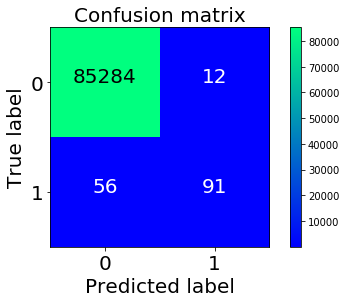

In [9]:
logstic_original = LogisticRegression(C = best_regularization_original , penalty = 'l1' , n_jobs = -1 , random_state = 0)
logstic_original.fit(X_train , y_train)
y_pred_original = logstic_original.predict(X_test)

# 計算Recall、Precision並畫出confusion matrix
cm = confusion_matrix(np.array(y_test) , np.array(y_pred_original))
plot_confusion_matrix(cm , classes = [0 , 1] , normalize = False , title = 'Confusion matrix')
recall = cm[1 , 1] / (cm[1 , 0] + cm[1 , 1])
precision = cm[1 , 1] / (cm[0 , 1] + cm[1 , 1])

print('Recall : {:.3f}'.format(recall))
print('Precision : {:.3f}'.format(precision))

決定下採樣數據集

In [10]:
# 得到所有正樣本的索引與個數
number_records_fraud = len(data[data['Class'] == 1])
fraud_index = np.array(data[data['Class'] == 1].index)

# 得到所有負樣本的索引
normal_index = data.loc[data['Class'] == 0].index

# 在負樣本中隨機採樣出正樣本個數的樣本，並取其索引
random_normal_index = np.random.choice(normal_index , number_records_fraud , replace = False)
random_normal_index = np.array(random_normal_index)

# 有了正、負樣本後，把它們的索引都拿到手
under_sample_index = np.concatenate([fraud_index , random_normal_index])

# 根據索引得到下採樣所有樣本點
under_sample_data = data.iloc[under_sample_index , :]

y_undersample = under_sample_data['Class']
X_undersample = under_sample_data.drop('Class' , axis = 1)

# 下採樣 樣本比例
print('正樣本所占整體比例 : {:.2%}'.format(len(under_sample_data[under_sample_data['Class'] == 0]) / len(under_sample_data)))
print('負樣本所占整體比例 : {:.2%}'.format(len(under_sample_data[under_sample_data['Class'] == 1]) / len(under_sample_data)))
print('下採樣策略總體樣本數量 : {}'.format(len(under_sample_data)))

正樣本所占整體比例 : 50.00%
負樣本所占整體比例 : 50.00%
下採樣策略總體樣本數量 : 984


In [11]:
# 下採樣數據集進行劃分
X_train_undersample , X_test_undersample , y_train_undersample , y_test_undersample = train_test_split(X_undersample ,
                                                                                                       y_undersample , 
                                                                                                       test_size = 0.3 , 
                                                                                                       random_state = 0)
print('下採樣訓練集包含樣本數量 : {}'.format(len(X_train_undersample)))
print('下採樣測試集包含樣本數量 : {}'.format(len(X_test_undersample)))
print('下採樣樣本總數 : {}'.format(len(X_train_undersample) + len(X_test_undersample)))

下採樣訓練集包含樣本數量 : 688
下採樣測試集包含樣本數量 : 296
下採樣樣本總數 : 984


觀察不同regularization之參數應用在下採樣數據集的交叉驗證結果

In [12]:
results_table = printing_Kfold_scores(X_train_undersample , y_train_undersample)

best_regularization_undersample = results_table.loc[results_table['Mean Recall score'].astype('float32').idxmax()]['regularization']
print('\n效果最好的模型之regularization參數 = {}'.format(best_regularization_undersample))


 --------------------------------------------------
regularization strength :  0.01
Iteration : 0 , Recall : 0.932 ,  precision : 0.764
Iteration : 1 , Recall : 0.918 ,  precision : 0.736
Iteration : 2 , Recall : 1.000 ,  precision : 0.621
Iteration : 3 , Recall : 0.959 ,  precision : 0.724
Iteration : 4 , Recall : 0.970 ,  precision : 0.688
平均Recall : 0.956

 --------------------------------------------------
regularization strength :  0.1
Iteration : 0 , Recall : 0.836 ,  precision : 1.000
Iteration : 1 , Recall : 0.863 ,  precision : 0.984
Iteration : 2 , Recall : 0.932 ,  precision : 0.965
Iteration : 3 , Recall : 0.932 ,  precision : 0.945
Iteration : 4 , Recall : 0.894 ,  precision : 0.983
平均Recall : 0.891

 --------------------------------------------------
regularization strength :  1
Iteration : 0 , Recall : 0.849 ,  precision : 0.984
Iteration : 1 , Recall : 0.877 ,  precision : 0.985
Iteration : 2 , Recall : 0.983 ,  precision : 0.935
Iteration : 3 , Recall : 0.946 ,  preci

下採樣方案應用在原始測試集中的結果<br>
可以發現下採樣方案應用在原始測試集，所計算的Recall比起logstic_original的Recall成長了不少，算是有進步<br>
但是真正的負樣本有蠻大一部分被預測成正樣本<br>
因為下採樣方案會讓模型預測出正樣本的機率增加，但這樣會導致真正的負樣本很容易被預測成正樣本，會導致Precision變的非常小

下採樣方案應用在原始測試集的Recall : 0.912
下採樣方案應用在原始測試集的Precision : 0.013


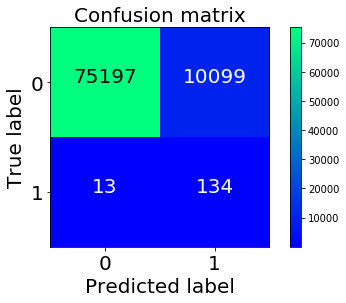

In [13]:
logstic_undersample = LogisticRegression(C = best_regularization_undersample , penalty = 'l1' , n_jobs = -1 , random_state = 0) 
logstic_undersample.fit(X_train_undersample , y_train_undersample)
y_pred_undersample = logstic_undersample.predict(X_test)

# 計算Recall、Precision並畫出confusion matrix
cm = confusion_matrix(np.array(y_test) , np.array(y_pred_undersample))
plot_confusion_matrix(cm , classes = [0 , 1] , normalize = False , title = 'Confusion matrix')
recall = cm[1 , 1] / (cm[1 , 0] + cm[1 , 1])
precision = cm[1 , 1] / (cm[0 , 1] + cm[1 , 1])

print('下採樣方案應用在原始測試集的Recall : {:.3f}'.format(recall))
print('下採樣方案應用在原始測試集的Precision : {:.3f}'.format(precision))

### SMOTE上採樣方案

利用SMOTE算法來進行樣本生成，這樣正樣本和負樣本數量就是一致的

In [14]:
oversampler = SMOTE(random_state = 0)
X_train_SMOTE , y_train_SMOTE = oversampler.fit_sample(X_train , y_train)

訓練集樣本數量

In [15]:
print('負樣本數量 : {} , 負樣本比例 : {:.2%}'.format((y_train_SMOTE == 0).sum() , (y_train_SMOTE == 0).sum() / len(y_train_SMOTE)))
print('正樣本數量 : {} , 正樣本比例 : {:.2%}'.format((y_train_SMOTE == 1).sum() , (y_train_SMOTE == 1).sum() / len(y_train_SMOTE)))
X_train_SMOTE = pd.DataFrame(X_train_SMOTE)
y_train_SMOTE = pd.DataFrame(y_train_SMOTE)

負樣本數量 : 199019 , 負樣本比例 : 50.00%
正樣本數量 : 199019 , 正樣本比例 : 50.00%


In [16]:
results_table = printing_Kfold_scores(X_train_SMOTE , y_train_SMOTE)

best_regularization_SMOTE = results_table.loc[results_table['Mean Recall score'].astype('float32').idxmax()]['regularization']
print('\n效果最好的模型之regularization參數 = {}'.format(best_regularization_SMOTE))


 --------------------------------------------------
regularization strength :  0.01
Iteration : 0 , Recall : 0.929 ,  precision : 0.037
Iteration : 1 , Recall : 0.912 ,  precision : 0.033
Iteration : 2 , Recall : 0.913 ,  precision : 0.973
Iteration : 3 , Recall : 0.897 ,  precision : 1.000
Iteration : 4 , Recall : 0.897 ,  precision : 1.000
平均Recall : 0.910

 --------------------------------------------------
regularization strength :  0.1
Iteration : 0 , Recall : 0.929 ,  precision : 0.037
Iteration : 1 , Recall : 0.920 ,  precision : 0.033
Iteration : 2 , Recall : 0.915 ,  precision : 0.973
Iteration : 3 , Recall : 0.899 ,  precision : 1.000
Iteration : 4 , Recall : 0.899 ,  precision : 1.000
平均Recall : 0.912

 --------------------------------------------------
regularization strength :  1
Iteration : 0 , Recall : 0.929 ,  precision : 0.037
Iteration : 1 , Recall : 0.920 ,  precision : 0.033
Iteration : 2 , Recall : 0.915 ,  precision : 0.973
Iteration : 3 , Recall : 0.899 ,  preci

過採樣方案應用在原始測試集中的結果<br>
可以發現下採樣方案與過採樣方案的recall非常相近，但是下採樣方案的precision卻非常低，代表採用下採樣方案方式的模型是遜於過採樣樣方案的

上採樣SMOTE方案應用在原始測試集的Recall : 0.918
上採樣SMOTE方案應用在原始測試集的Precision : 0.060


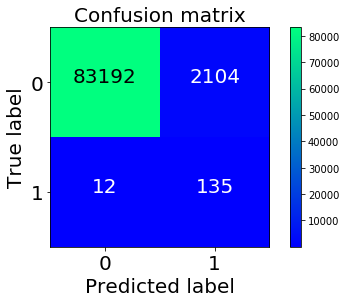

In [17]:
logstic_SMOTE = LogisticRegression(C = best_regularization_SMOTE , penalty = 'l1' , n_jobs = -1 , random_state = 0)
logstic_SMOTE.fit(X_train_SMOTE , y_train_SMOTE)
y_pred_SMOTE = logstic_SMOTE.predict(X_test)

# 計算Recall、Precision並畫出confusion matrix
cm = confusion_matrix(np.array(y_test) , np.array(y_pred_SMOTE))
plot_confusion_matrix(cm , classes = [0 , 1] , normalize = False , title = 'Confusion matrix')

recall = cm[1 , 1] / (cm[1 , 0] + cm[1 , 1])
precision = cm[1 , 1] / (cm[0 , 1] + cm[1 , 1])

print('上採樣SMOTE方案應用在原始測試集的Recall : {:.3f}'.format(recall))
print('上採樣SMOTE方案應用在原始測試集的Precision : {:.3f}'.format(precision))

## 下採樣方案 vs 上採樣方案

由於本程式所採用數據的標籤非常不平衡，負樣本的數量遠大於正樣本<br>
如果只比較Recall是無法分出好的模型與爛的模型<br>
這裡要探討不同模型在ROC_Curve與PR_Curve上的表現<br>
(ROC_Curve由於兼顧正例與負例，所以適用於評估分類器的整體性能，相比而言PR_Curve完全聚焦於正例)

In [18]:
# 輸出模型預測出正樣本的機率
y_prob_undersample = logstic_undersample.predict_proba(X_test)[:,1]
y_prob_SMOTE = logstic_SMOTE.predict_proba(X_test)[:,1]

在這種負樣本的數量遠大於正樣本的數據中，負樣本的數目眾多使FPR的增長不明顯，最後ROC Curve呈現一個過分樂觀的估計<br>
FPR = FP / FP + TN，分母(負樣本的數目)是遠大於分子的，導致FP的大幅增長只能換來FPR的微小改變<br>
也就是大量負樣本被錯判成正樣本，在ROC Curve上卻無法直觀地看出來(把原本的ROC Curve的x與y軸互換即可明顯看出來)<br>

下採樣方案與過採樣方案建出來模型的ROC Curve與計算的Auc Score都差不多，但兩者的表現卻天差地遠

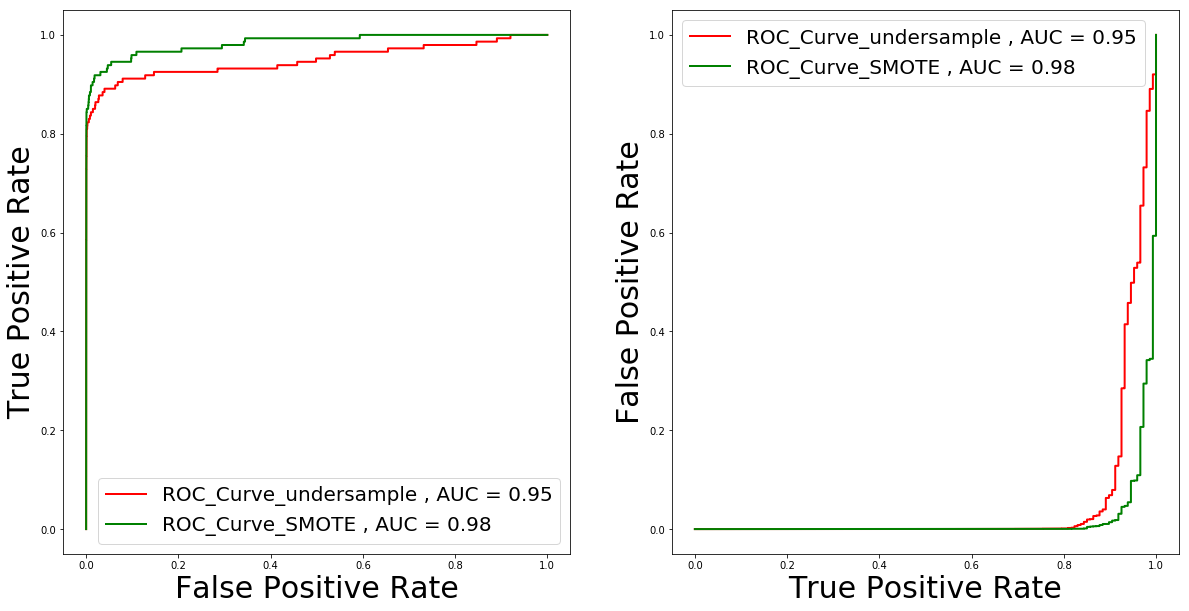

In [19]:
# 計算不同threshold下的false positive rate與true positive rate
fpr_undersample , tpr_undersample , _ = roc_curve(y_test , y_prob_undersample)
fpr_SMOTE , tpr_SMOTE , _ = roc_curve(y_test , y_prob_SMOTE)

# 計算auc score
roc_auc_undersample = auc(fpr_undersample , tpr_undersample)
roc_auc_SMOTE = auc(fpr_SMOTE , tpr_SMOTE)

fig , ax = plt.subplots(1 , 2 , figsize = (20 , 10))
ax[0].plot(fpr_undersample , tpr_undersample , lw = 2 , color = 'red' , label = 'ROC_Curve_undersample , AUC = {:.2f}'.format(roc_auc_undersample))
ax[0].plot(fpr_SMOTE , tpr_SMOTE , lw = 2 , color = 'green' , label = 'ROC_Curve_SMOTE , AUC = {:.2f}'.format(roc_auc_SMOTE))
ax[0].set_xlabel('False Positive Rate' , fontsize = 30)
ax[0].set_ylabel('True Positive Rate' , fontsize = 30)
ax[0].legend(loc = 'best' , fontsize = 20)

# x與y軸互換
ax[1].plot(tpr_undersample , fpr_undersample , lw = 2 , color = 'red' , label = 'ROC_Curve_undersample , AUC = {:.2f}'.format(roc_auc_undersample))
ax[1].plot(tpr_SMOTE , fpr_SMOTE , lw = 2 , color = 'green' , label = 'ROC_Curve_SMOTE , AUC = {:.2f}'.format(roc_auc_SMOTE))
ax[1].set_xlabel('True Positive Rate' , fontsize = 30)
ax[1].set_ylabel('False Positive Rate' , fontsize = 30)
ax[1].legend(loc = 'best' , fontsize = 20)

但在這種負樣本的數量遠大於正樣本的數據中，不好的模型會導致Recall變大的同時(Threshold變大)，FP也會急速的上升，導致Prescion會急速的衰減<br>
而且計算PR Curve下的面積來當作模型優劣的標準也會比較客觀<br>
所以在此情況下PR Curve比起ROC Curve是比較適合於當作衡量performance的工具

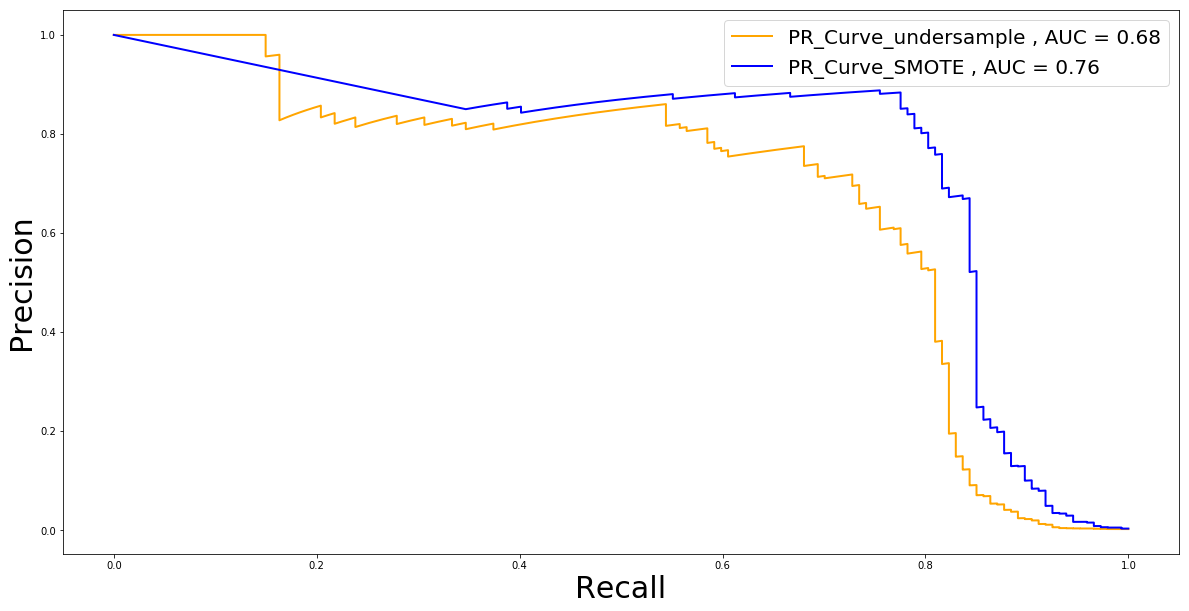

In [20]:
# 計算不同threshold下的precision與recall
precision_undersample , recall_undersample , _ = precision_recall_curve(y_test , y_prob_undersample)
precision_SMOTE , recall_SMOTE , _ = precision_recall_curve(y_test , y_prob_SMOTE)

# 計算auc score
pr_auc_undersample = auc(recall_undersample , precision_undersample)
pr_auc_SMOTE = auc(recall_SMOTE , precision_SMOTE)

fig , ax = plt.subplots(1 , 1 , figsize = (20 , 10))
ax.plot(recall_undersample , precision_undersample , lw = 2 , color = 'orange' , label = 'PR_Curve_undersample , AUC = {:.2f}'.format(pr_auc_undersample))
ax.plot(recall_SMOTE , precision_SMOTE , lw = 2 , color = 'blue' , label = 'PR_Curve_SMOTE , AUC = {:.2f}'.format(pr_auc_SMOTE))
ax.set_xlabel('Recall' , fontsize = 30)
ax.set_ylabel('Precision' , fontsize = 30)
ax.legend(loc = 'best' , fontsize = 20)